## Part 1 ##

In [68]:
import numpy as np
from sklearn.linear_model import LassoCV as LassoCV
from sklearn.linear_model import Lasso as Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import time

In [60]:
## Note: got this func from Felix ##
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    
    X = rng.standard_normal(size=(n, p))
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]
    

number of datasets to generate: 60
k = 0,  time ellapsed: 16.57171058654785 seconds
k = 1,  time ellapsed: 30.66438579559326 seconds
k = 2,  time ellapsed: 43.90308380126953 seconds
k = 3,  time ellapsed: 58.16840982437134 seconds
k = 4,  time ellapsed: 72.0560953617096 seconds
k = 5,  time ellapsed: 82.2004714012146 seconds
k = 6,  time ellapsed: 90.03624415397644 seconds
k = 7,  time ellapsed: 99.52705335617065 seconds
k = 8,  time ellapsed: 107.49247407913208 seconds
k = 9,  time ellapsed: 116.05648159980774 seconds
k = 10,  time ellapsed: 123.78083562850952 seconds
k = 11,  time ellapsed: 131.65451836585999 seconds
k = 12,  time ellapsed: 140.57071089744568 seconds
k = 13,  time ellapsed: 148.6094455718994 seconds
k = 14,  time ellapsed: 154.93021845817566 seconds
k = 15,  time ellapsed: 159.8231165409088 seconds
k = 16,  time ellapsed: 164.38696479797363 seconds
k = 17,  time ellapsed: 168.68829774856567 seconds
k = 18,  time ellapsed: 173.75630712509155 seconds
k = 19,  time ella

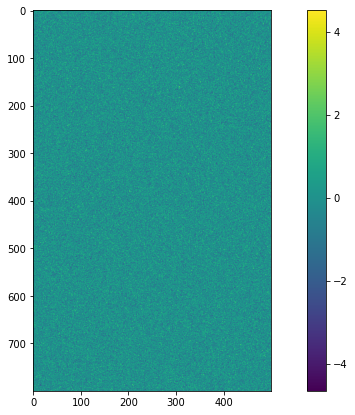

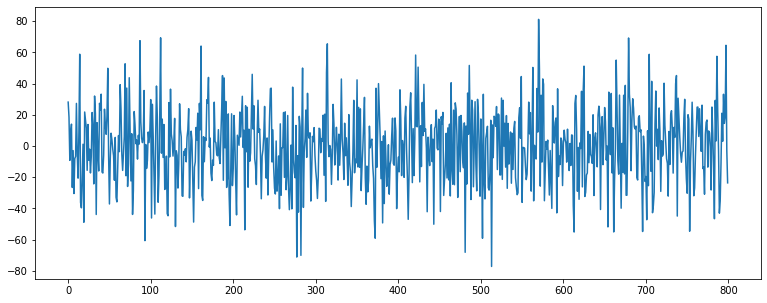

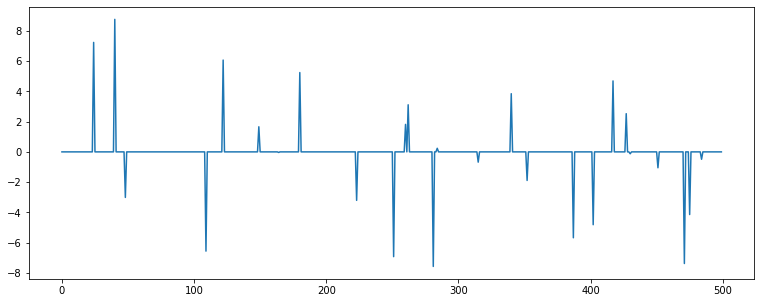

k = 31,  time ellapsed: 208.0090982913971 seconds
k = 32,  time ellapsed: 210.15680289268494 seconds
k = 33,  time ellapsed: 211.9718313217163 seconds
k = 34,  time ellapsed: 214.06220626831055 seconds
k = 35,  time ellapsed: 215.4658637046814 seconds
k = 36,  time ellapsed: 216.76104474067688 seconds
k = 37,  time ellapsed: 218.60733461380005 seconds
k = 38,  time ellapsed: 220.81082463264465 seconds
k = 39,  time ellapsed: 222.5509717464447 seconds
k = 40,  time ellapsed: 225.31886625289917 seconds
k = 41,  time ellapsed: 227.98492693901062 seconds
k = 42,  time ellapsed: 230.69718217849731 seconds
k = 43,  time ellapsed: 232.74785947799683 seconds
k = 44,  time ellapsed: 235.22765731811523 seconds
k = 45,  time ellapsed: 237.34328603744507 seconds
k = 46,  time ellapsed: 239.15078449249268 seconds
k = 47,  time ellapsed: 240.91696643829346 seconds
k = 48,  time ellapsed: 242.7347445487976 seconds
k = 49,  time ellapsed: 244.71182441711426 seconds
k = 50,  time ellapsed: 246.58302235

In [74]:
p = 500
n_vector = [100, 300, 400]
n_test = 500
sparsity_vector = [0.75, 0.9, 0.95, 0.99]
SNR = 5.0
beta_scale = 5.0
nr_runs = 5
rng = np.random.default_rng()

nr_datasets = int(len(n_vector)*len(sparsity_vector)*nr_runs)

lambda_mins = np.zeros(nr_datasets)
lambda_1ses = np.zeros(nr_datasets)
MSE_train_min = np.zeros(nr_datasets)
MSE_test_min = np.zeros(nr_datasets)
MSE_train_1se = np.zeros(nr_datasets)
MSE_test_1se = np.zeros(nr_datasets)


k = 0
illustrate = True
verbose = True

if(verbose):
    print(f"number of datasets to generate: {nr_datasets}")
    t0 = time.time()
for n in n_vector:
    for sparsity in sparsity_vector:
        for i in range(nr_runs):
            X, y, beta = simulate_data(n + n_test, p, rng, sparsity = sparsity, SNR = SNR, beta_scale = SNR)
            X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                                test_size = round(n_test/(n_test + n)),
                                                                random_state = 0)
            
            lasso = LassoCV().fit(X_train,y_train)
            alpha_min = lasso.alpha_
            lambda_mins[k] = alpha_min
            ## Note: got this paragraph from Felix ##
            cv_mean = np.mean(lasso.mse_path_, axis=1)
            cv_std = np.std(lasso.mse_path_, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
                (cv_mean >= cv_mean[idx_min_mean])
            )[0][0]
            alpha_1se = lasso.alphas_[idx_alpha]
            
            MSE_train_min[k] = cv_mean[idx_min_mean]
            MSE_train_1se[k] = cv_mean[idx_alpha]
            lambda_1ses[k] = alpha_1se
            
            pred_min = lasso.predict(X_test)
            MSE_test_min[k] = mse(pred_min, y_test)
            
            lasso_1se = Lasso(alpha = alpha_1se).fit(X_train, y_train)
            pred_1se = lasso_1se.predict(X_test)
            MSE_test_1se[k] = mse(pred_1se,y_test)
            
            
            
            if(verbose):
                t1 = time.time()
                print(f"k = {k},  time ellapsed: {t1-t0} seconds")
            if(illustrate and k == 30):
                plt.rcParams["figure.figsize"]=13,7
                plt.imshow(X)
                plt.colorbar()
                plt.show()
                plt.rcParams["figure.figsize"]=13,5
                plt.plot(y)
                plt.show()
                plt.plot(beta)
                plt.show()
            k += 1

if(verbose):
    print(f"Total number of datasets generated: {k}")
    t2 = time.time()
    print(f"Total time ellapsed: {t2-t0} seconds")

Total number of datasets generated: 60
Total time ellapsed: 416.264839887619 seconds


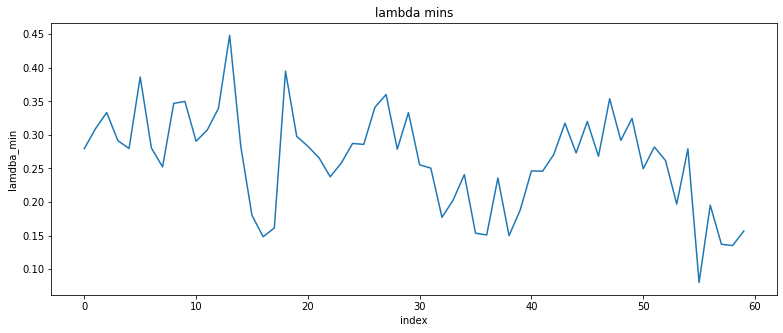

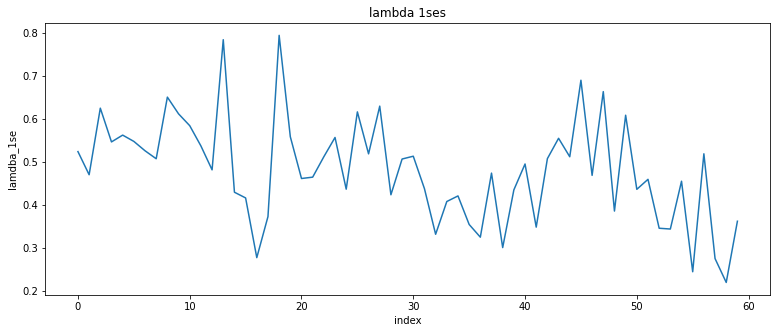

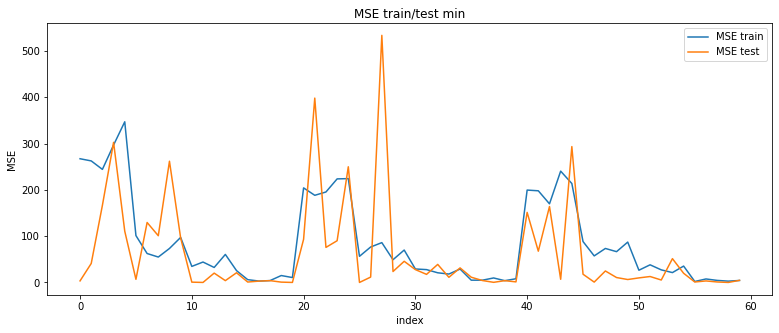

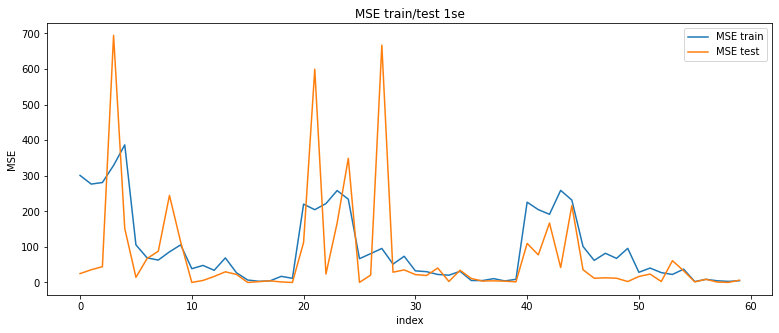

In [76]:
if(verbose):
    print(f"Total number of datasets generated: {k}")
    t2 = time.time()
    print(f"Total time ellapsed: {t2-t0} seconds")
if(illustrate):
    plt.plot(lambda_mins)
    plt.title("lambda mins")
    plt.xlabel("index")
    plt.ylabel("lamdba_min")
    plt.show()
    
    plt.plot(lambda_1ses)
    plt.title("lambda 1ses")
    plt.xlabel("index")
    plt.ylabel("lamdba_1se")
    plt.show()
    
    
    plt.plot(MSE_train_min, label = 'MSE train')
    plt.plot(MSE_test_min, label = 'MSE test')
    plt.title("MSE train/test min")
    plt.xlabel("index")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()
    
    plt.plot(MSE_train_1se, label = 'MSE train')
    plt.plot(MSE_test_1se, label = 'MSE test')
    plt.title("MSE train/test 1se")
    plt.xlabel("index")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()
